In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric, add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import warnings

warnings.simplefilter("ignore")

In [3]:
path = os.getcwd()
path = os.path.join(path, 'DATA')

file_paths = {}
for file in os.listdir(path):
  file_paths[file.split('.')[0]] = os.path.join(path, file)
for key, path in file_paths.items():
  exec(f"{key}_df = pd.read_csv(path)")


In [4]:
train_df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
df = train_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.strftime('%A')
df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion day_of_week  
0                  0     Tuesday  
1                  0     Tuesday  
2                  0     Tuesday  
3                  0     Tuesday  
4                  0     Tuesday  
...              ...         ...  
3000883            0     Tuesday  
3000884            1     Tuesday  
3000885          148     Tuesday  
3000886            8     Tuesday  
3000887            0     Tuesday  

[3000888 rows x 7 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   day_of_week  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 160.3+ MB


In [8]:
np.random.seed(123)
ndr = np.random.choice(df.store_nbr.unique())

In [9]:
df_nbr = df[df['store_nbr'] == ndr]
df_nbr = df_nbr[['date', 'sales', 'day_of_week']]
df_nbr

date     sales day_of_week
1485    2013-01-01     0.000     Tuesday
1486    2013-01-01     0.000     Tuesday
1487    2013-01-01     0.000     Tuesday
1488    2013-01-01     0.000     Tuesday
1489    2013-01-01     0.000     Tuesday
...            ...       ...         ...
3000619 2017-08-15   356.510     Tuesday
3000620 2017-08-15    73.852     Tuesday
3000621 2017-08-15  2027.374     Tuesday
3000622 2017-08-15   219.000     Tuesday
3000623 2017-08-15    15.314     Tuesday

[55572 rows x 3 columns]

In [10]:
df_nbr.isna().sum()

date           0
sales          0
day_of_week    0
dtype: int64

In [11]:
grouped_df = df_nbr.groupby('date').agg({'sales': 'sum', 'day_of_week': 'first'}).reset_index()
grouped_df

date         sales day_of_week
0    2013-01-01      0.000000     Tuesday
1    2013-01-02  16576.132000   Wednesday
2    2013-01-03  11066.465040    Thursday
3    2013-01-04  12147.440000      Friday
4    2013-01-05  17930.364000    Saturday
...         ...           ...         ...
1679 2017-08-11  21339.243004      Friday
1680 2017-08-12  19413.958001    Saturday
1681 2017-08-13  21221.233000      Sunday
1682 2017-08-14  18468.114000      Monday
1683 2017-08-15  16879.121004     Tuesday

[1684 rows x 3 columns]

In [12]:
grouped_df[grouped_df['sales'] == 0]
grouped_df = grouped_df[grouped_df['sales'] != 0]
grouped_df

date         sales day_of_week
1    2013-01-02  16576.132000   Wednesday
2    2013-01-03  11066.465040    Thursday
3    2013-01-04  12147.440000      Friday
4    2013-01-05  17930.364000    Saturday
5    2013-01-06  16832.681020      Sunday
...         ...           ...         ...
1679 2017-08-11  21339.243004      Friday
1680 2017-08-12  19413.958001    Saturday
1681 2017-08-13  21221.233000      Sunday
1682 2017-08-14  18468.114000      Monday
1683 2017-08-15  16879.121004     Tuesday

[1679 rows x 3 columns]

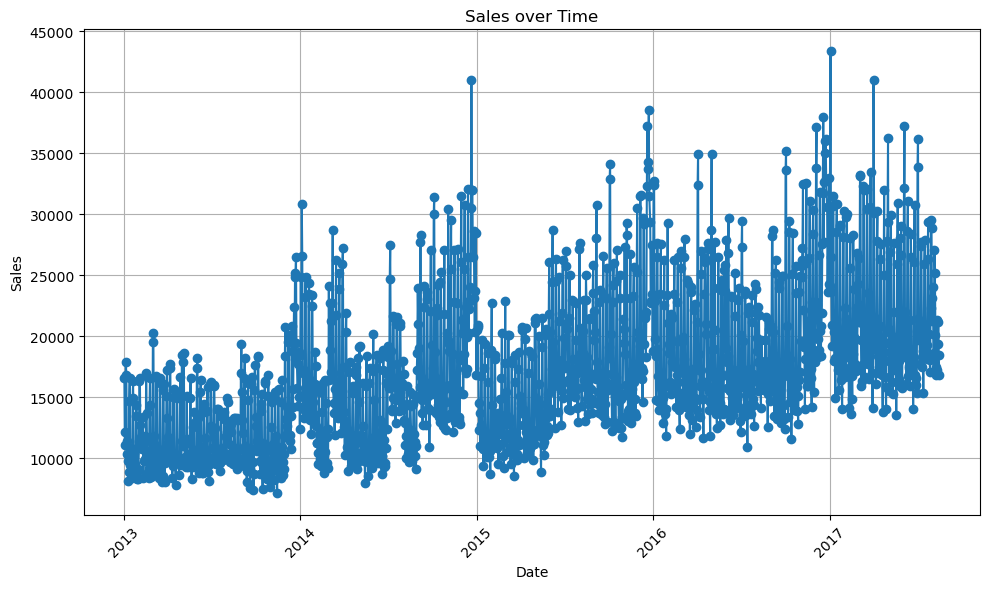

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['date'], grouped_df['sales'], marker='o', linestyle='-')
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45) # Повертаємо підписи осі X на 45 градусів для зручності
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
window_size = 7
grouped_df['SMA'] = grouped_df['sales'].rolling(window=window_size, min_periods=1).mean()
grouped_df.head(10)

date         sales day_of_week           SMA
1  2013-01-02  16576.132000   Wednesday  16576.132000
2  2013-01-03  11066.465040    Thursday  13821.298520
3  2013-01-04  12147.440000      Friday  13263.345680
4  2013-01-05  17930.364000    Saturday  14430.100260
5  2013-01-06  16832.681020      Sunday  14910.616412
6  2013-01-07  11405.104989      Monday  14326.364508
7  2013-01-08  10323.583000     Tuesday  13754.538578
8  2013-01-09   9822.025000   Wednesday  12789.666150
9  2013-01-10   8124.360000    Thursday  12369.365430
10 2013-01-11   8876.278010      Friday  11902.056574

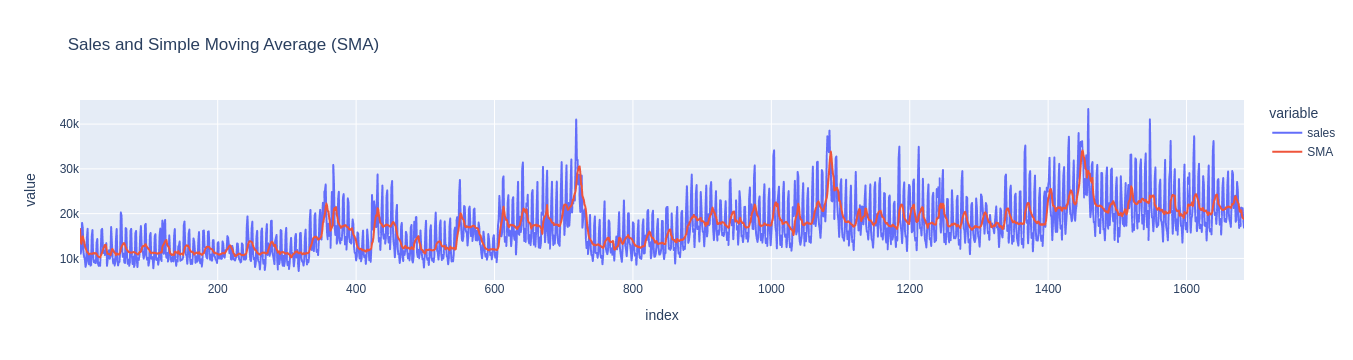

In [15]:
fig = px.line(grouped_df, x=grouped_df.index, y=["sales", "SMA"], title="Sales and Simple Moving Average (SMA)")
fig.show()

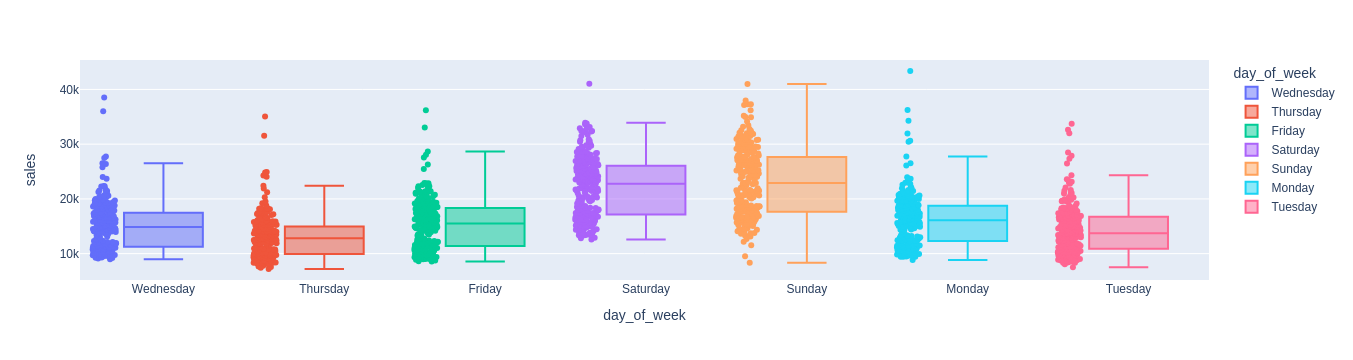

In [16]:
fig = px.box(grouped_df, x='day_of_week', y="sales", color="day_of_week",
       boxmode="overlay", points='all')
fig.show()

In [17]:
fbp_set = (grouped_df[['date', 'sales']])
fbp_set.rename(columns={"date": "ds", "sales":"y"}, inplace=True)
fbp_set.head()

ds            y
1 2013-01-02  16576.13200
2 2013-01-03  11066.46504
3 2013-01-04  12147.44000
4 2013-01-05  17930.36400
5 2013-01-06  16832.68102

In [18]:
window = 30
train, test = fbp_set[:-window], fbp_set[-window:]

In [19]:
model = Prophet()
model.fit(train)

18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:47 - cmdstanpy - INFO - Chain [1] done processing


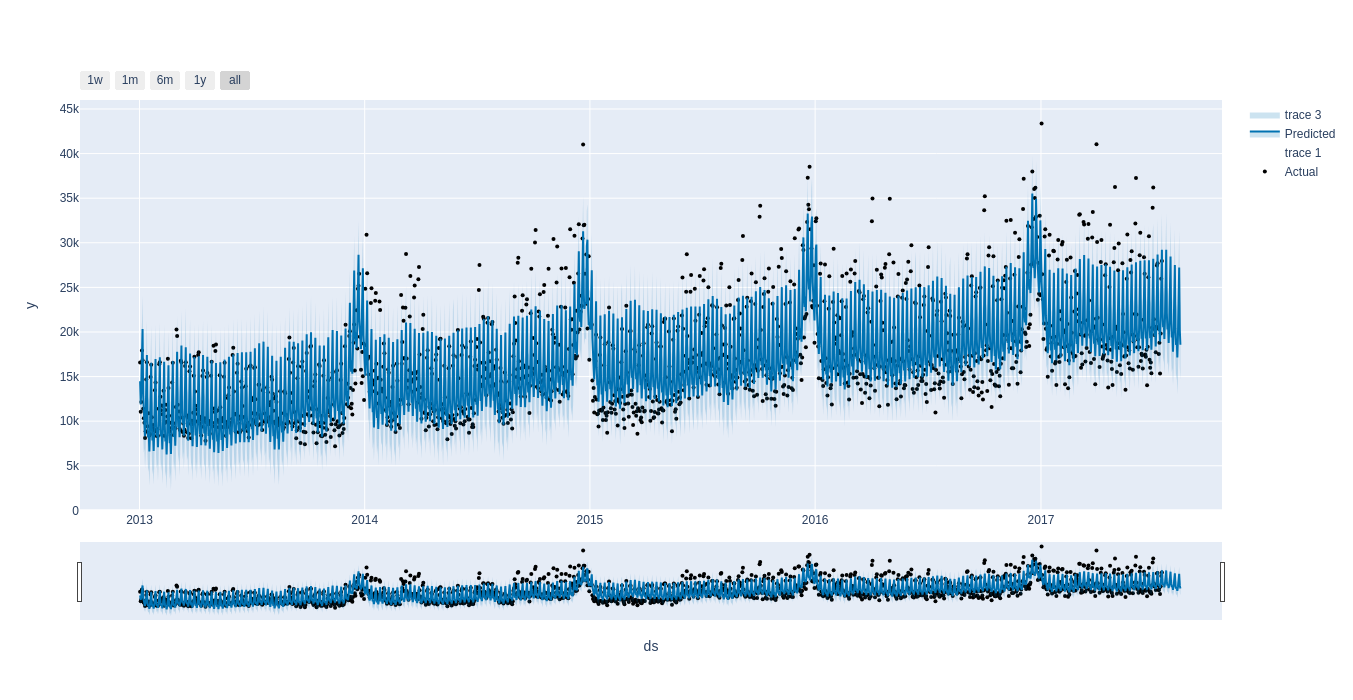

In [20]:
future_sales = model.make_future_dataframe(periods=30)
forecast = model.predict(future_sales)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
plot_components_plotly(model, forecast, figsize=(1000, 300))
plot = plot_plotly(model, forecast, figsize=(1400, 700))
plot.update_layout(showlegend=True)

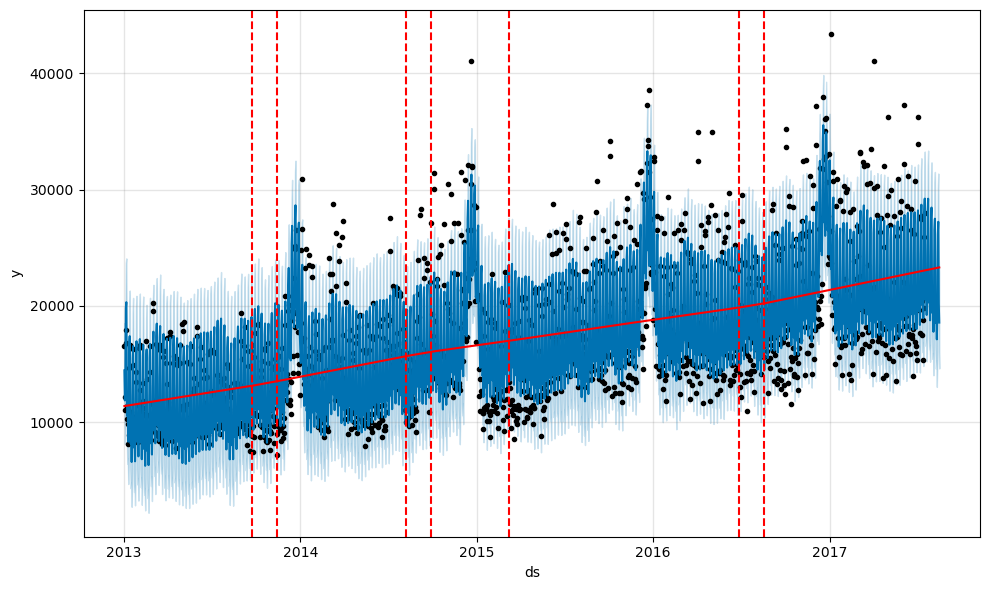

In [21]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

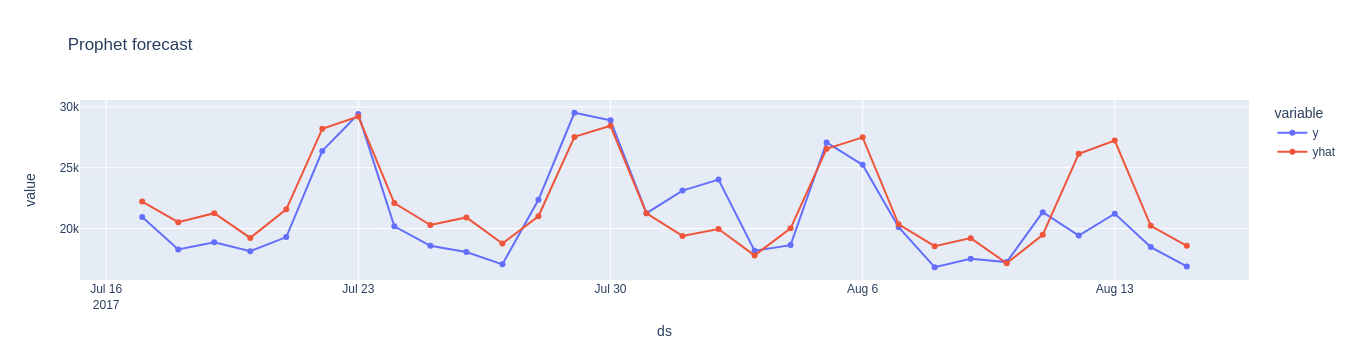

In [22]:
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast")
fig.show()

In [24]:
MAE = mean_absolute_error(benchmark_df['y'], benchmark_df['yhat'])
print('MAE : {:.2f}'.format(MAE))
MSE = mean_squared_error(benchmark_df['y'], benchmark_df['yhat'])
print('MSE : {:.2f}'.format(MSE))
MSLE = mean_squared_log_error(benchmark_df['y'], benchmark_df['yhat'])
print('MSLE : {:.2f}'.format(MSLE))

MAE : 1916.00
MSE : 6016433.46
MSLE : 0.01


20:10:44 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing


Period: 30 days


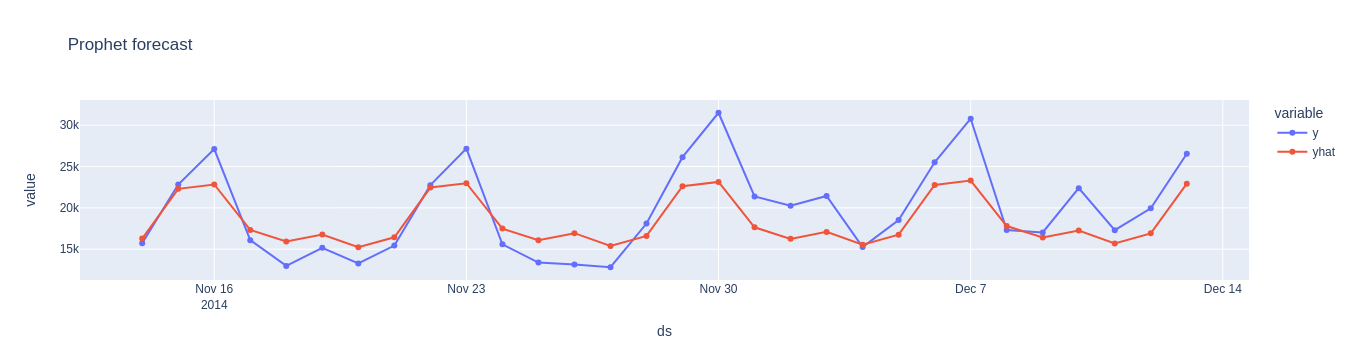

MAE: 2727.39
MSE: 11273387.52
MSLE: 0.03

Period: 90 days


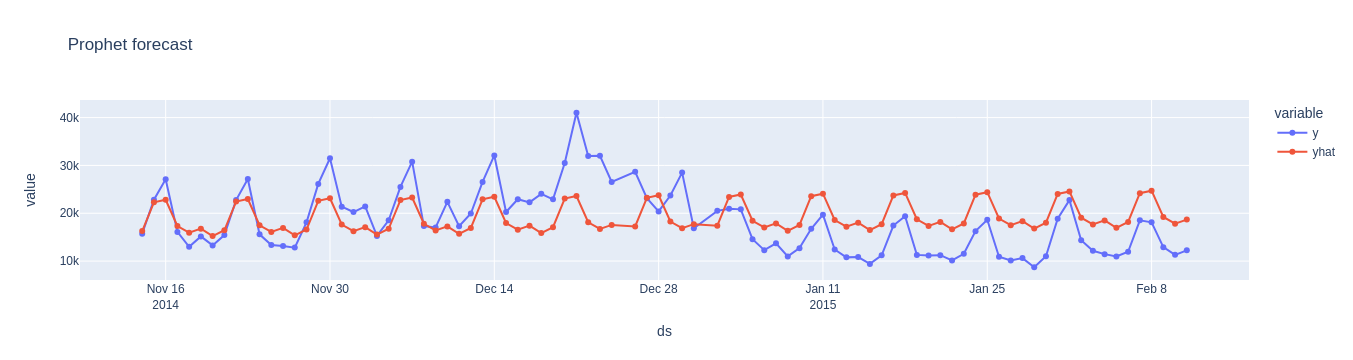

MAE: 5160.46
MSE: 36976490.92
MSLE: 0.11

Period: 180 days


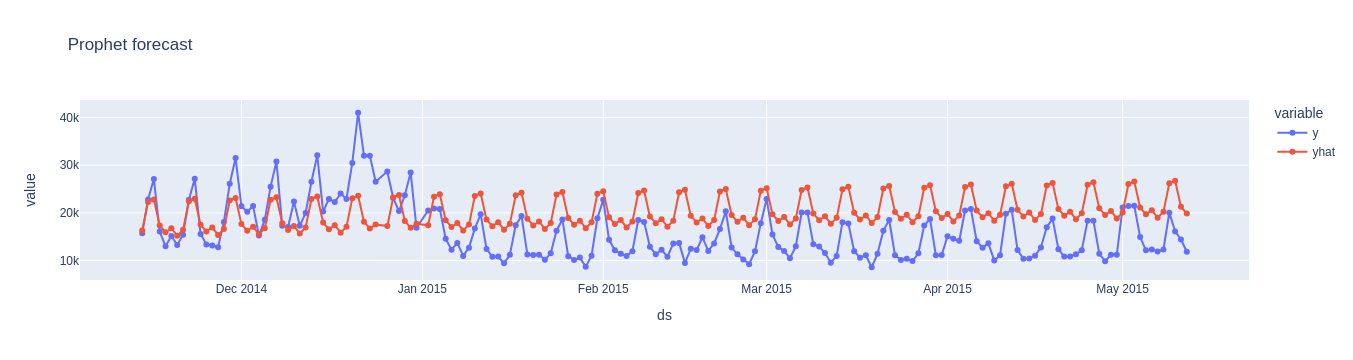

MAE: 6181.41
MSE: 46266774.23
MSLE: 0.16

Period: 270 days


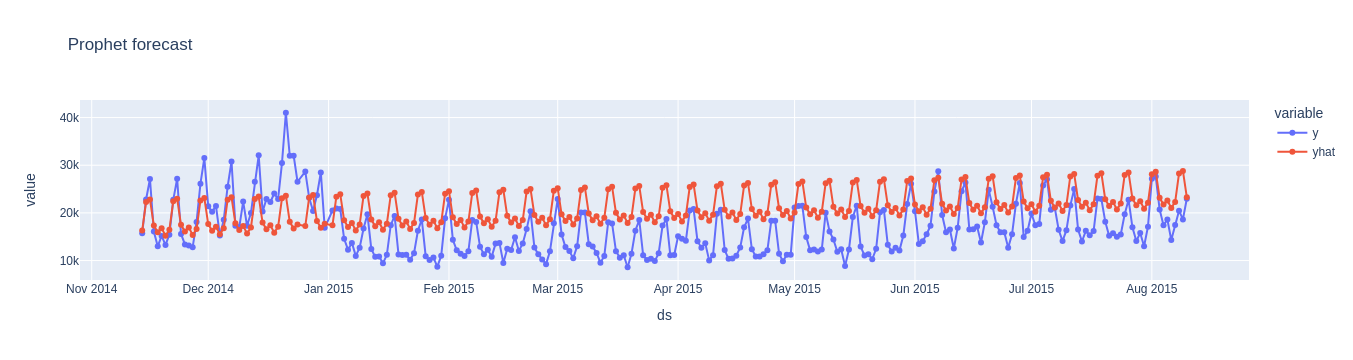

MAE: 5868.25
MSE: 41946982.45
MSLE: 0.14

Period: 365 days


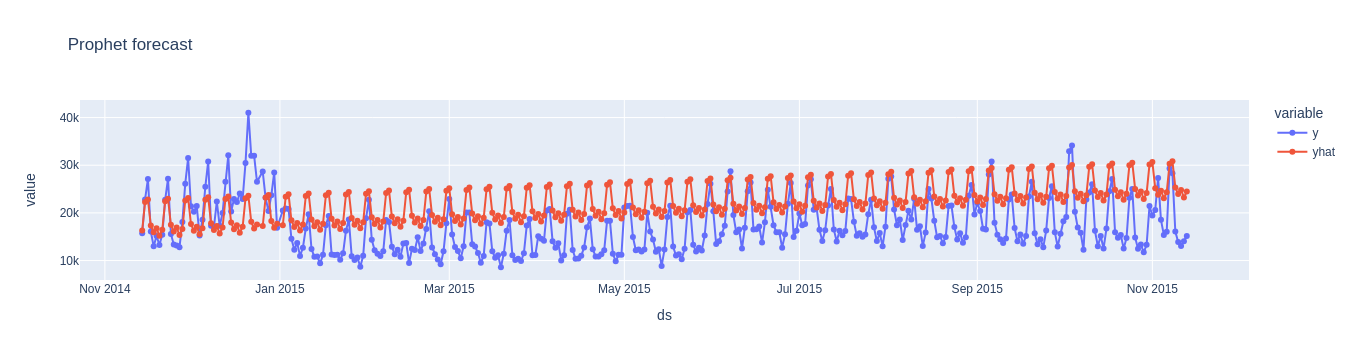

MAE: 6145.86
MSE: 45350253.78
MSLE: 0.14



In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
import plotly.express as px

warnings.simplefilter("ignore")

path = os.getcwd()
path = os.path.join(path, 'DATA')

file_paths = {}
for file in os.listdir(path):
    file_paths[file.split('.')[0]] = os.path.join(path, file)
for key, path in file_paths.items():
    exec(f"{key}_df = pd.read_csv(path)")
    
df = train_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.strftime('%A')

np.random.seed(123)
ndr = np.random.choice(df.store_nbr.unique())
df_nbr = df[df['store_nbr'] == ndr]
df_nbr = df_nbr[['date', 'sales', 'day_of_week']]

grouped_df = df_nbr.groupby('date').agg({'sales': 'sum', 'day_of_week': 'first'}).reset_index()
grouped_df = grouped_df[grouped_df['sales'] != 0]

fbp_set = (grouped_df[['date', 'sales']])
fbp_set.rename(columns={"date": "ds", "sales":"y"}, inplace=True)

periods = [30, 90, 180, 270, 365]
train, test = fbp_set[:-1000], fbp_set[-1000:]

model = Prophet()
model.fit(train)

for period in periods:

    future_sales = model.make_future_dataframe(periods=period)
    forecast = model.predict(future_sales)
      
    benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    benchmark_df = benchmark_df.dropna()
    MAE = mean_absolute_error(benchmark_df['y'], benchmark_df['yhat'])
    MSE = mean_squared_error(benchmark_df['y'], benchmark_df['yhat'])
    MSLE = mean_squared_log_error(benchmark_df['y'], benchmark_df['yhat'])

    print(f'Period: {period} days')
    fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast")
    fig.show()
    print(f'MAE: {MAE:.2f}')
    print(f'MSE: {MSE:.2f}')
    print(f'MSLE: {MSLE:.2f}\n')

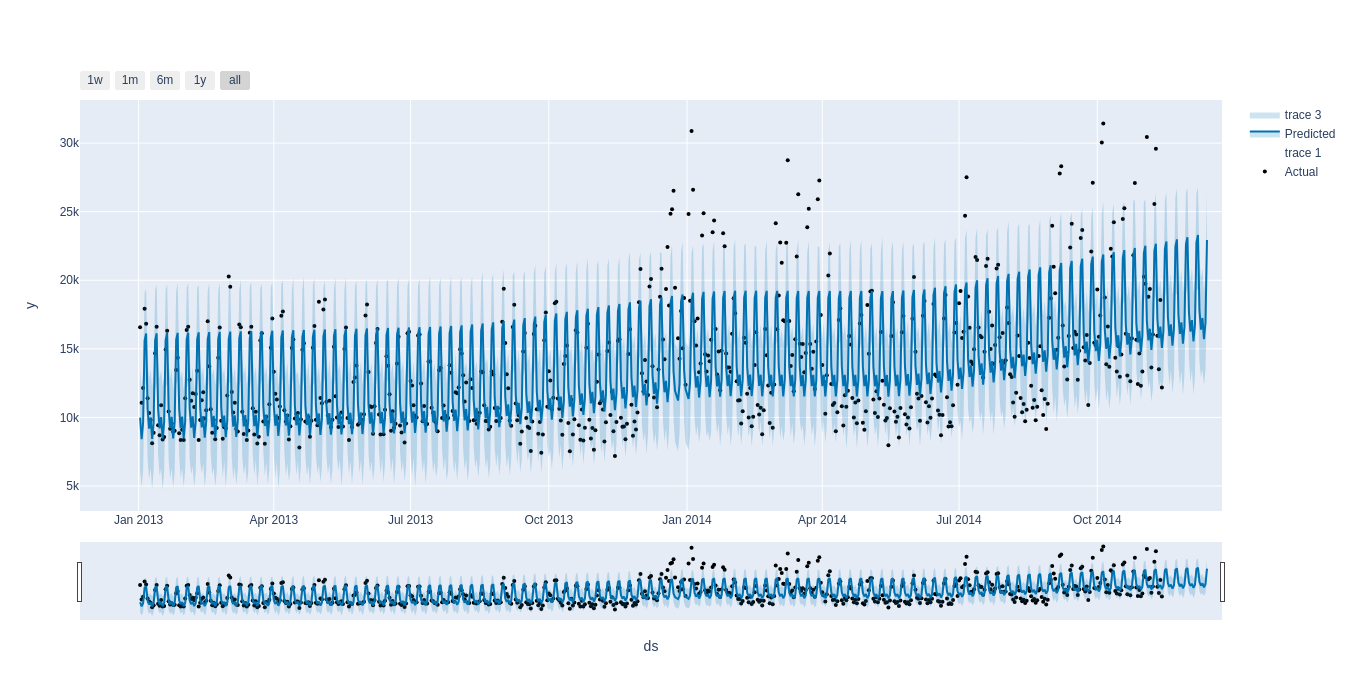

In [29]:
future_sales = model.make_future_dataframe(periods=30)
forecast = model.predict(future_sales)
plot_components_plotly(model, forecast, figsize=(1000, 300))
plot = plot_plotly(model, forecast, figsize=(1200, 700))
plot.update_layout(showlegend=True)